# Autoencoder

### Importing libraries

In [10]:
import keras
from keras import layers
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

### Making the Autoencoder Layer

In [ ]:
# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

### Making separate Encoder and Decoder Layers

In [3]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

### Compiling the Autoencoder object

In [4]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

### Loading the data

In [6]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

4422102/4422102 [==============================] - 78s 18us/step
(60000, 784)
(10000, 784)


### Training the Autoencoder

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50


2023-05-31 04:11:58.153390: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2023-05-31 04:11:58.344565: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


233/235 [============================>.] - ETA: 0s - loss: 0.4156

2023-05-31 04:12:01.371044: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.
2023-05-31 04:12:01.390000: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.


235/235 [==============================] - 3s 10ms/step - loss: 0.4151 - val_loss: 0.3444
Epoch 2/50
235/235 [==============================] - 2s 10ms/step - loss: 0.3295 - val_loss: 0.3228
Epoch 3/50
235/235 [==============================] - 2s 7ms/step - loss: 0.3137 - val_loss: 0.3099
Epoch 4/50
235/235 [==============================] - 2s 6ms/step - loss: 0.3037 - val_loss: 0.3021
Epoch 5/50
235/235 [==============================] - 1s 6ms/step - loss: 0.2972 - val_loss: 0.2971
Epoch 6/50
235/235 [==============================] - 2s 7ms/step - loss: 0.2926 - val_loss: 0.2931
Epoch 7/50
235/235 [==============================] - 2s 8ms/step - loss: 0.2894 - val_loss: 0.2904
Epoch 8/50
235/235 [==============================] - 2s 10ms/step - loss: 0.2875 - val_loss: 0.2891
Epoch 9/50
235/235 [==============================] - 2s 7ms/step - loss: 0.2864 - val_loss: 0.2882
Epoch 10/50
235/235 [==============================] - 1s 6ms/step - loss: 0.2857 - val_loss: 0.2876
Epoch 1

The validation loss achieved is val_loss: 0.2838

### Testing the Autoencoder

In [8]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

 28/313 [=>............................] - ETA: 0s 

2023-05-31 04:14:22.153292: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.


313/313 [==============================] - 0s 1ms/step


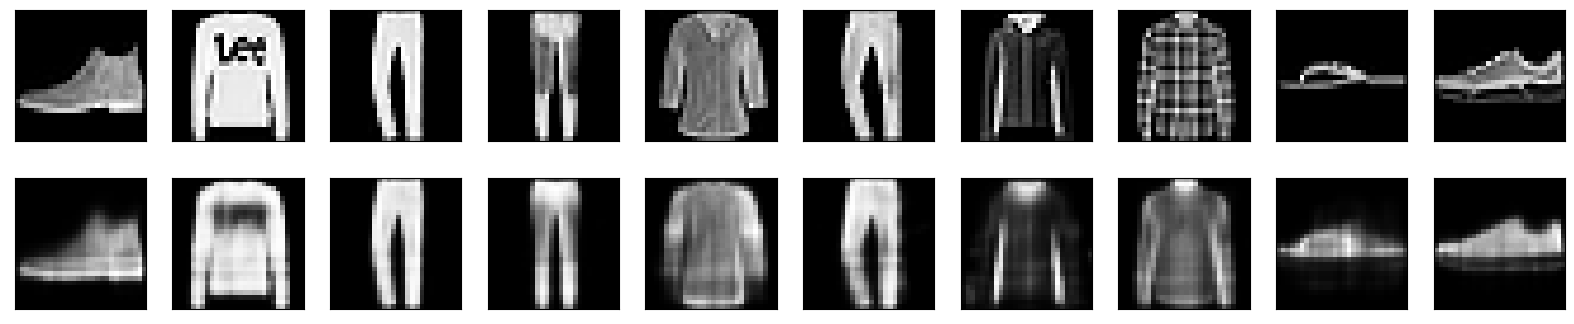

In [11]:
n = 10  # How many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Variational Autoencoder

In [20]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)



In [21]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [22]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [23]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [24]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [25]:
vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 8s 4ms/step - loss: 291.7843 - val_loss: 275.6074
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 271.4178 - val_loss: 269.8521
Epoch 3/100
1875/1875 [==============================] - 7s 4ms/step - loss: 267.4009 - val_loss: 267.2937
Epoch 4/100
1875/1875 [==============================] - 6s 3ms/step - loss: 265.3695 - val_loss: 265.6725
Epoch 5/100
1875/1875 [==============================] - 7s 4ms/step - loss: 263.9624 - val_loss: 264.7013
Epoch 6/100
1875/1875 [==============================] - 6s 3ms/step - loss: 262.9476 - val_loss: 263.8408
Epoch 7/100
1875/1875 [==============================] - 10s 5ms/step - loss: 262.0849 - val_loss: 262.8078
Epoch 8/100
1875/1875 [==============================] - 13s 7ms/step - loss: 261.4654 - val_loss: 262.2632
Epoch 9/100
1875/1875 [==============================] - 12s 6ms/step - loss: 260.9603 - val_loss: 262.1157
Epoch 10/100
1875/1875 [==========

1/1 [==============================] - 0s 98ms/step


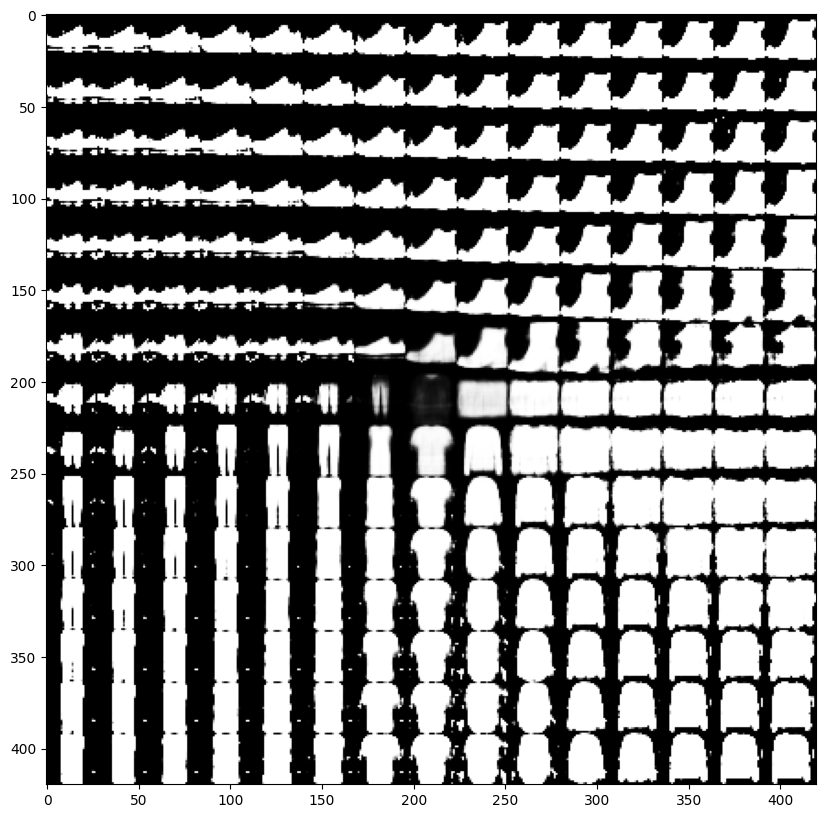

In [27]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()